# Inverting gradient attack

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam, AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset, random_split
from torchvision.transforms import v2 as T
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.functional import total_variation
import torchinfo
from image_classification.utils import trange

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## ResNet-18

In [3]:
from image_classification.models import ResNet18
from image_classification.datasets import cifar10_train_test, cifar100_train_test
from image_classification.nn import train_loop, test_epoch

Using cuda device


In [4]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by theses datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N = len(training_data) - N_val
# This works since training data is already shuffled
training_data, val_data = training_data.split([N, N_val])

batch_size = 100
N, N_val, N_test

Loading CIFAR-10


(45000, 5000, 10000)

In [5]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)

### Hyperparameters

In [6]:
lr = 1e-3
weight_decay = 5e-4
# For learning rate scheduling
max_lr = 0.1

epochs = 6
steps_per_epoch = N // batch_size

lr_sched_params = dict(max_lr=max_lr, epochs=epochs, steps_per_epoch=steps_per_epoch)

criterion = CrossEntropyLoss()

top_k = {10: 1, 100: 5}[num_classes]

metric = MulticlassAccuracy(num_classes=num_classes, top_k=top_k)

### Optimizer (TODO: compare SGD & Adam)

In [7]:
def make_optimizer(model: nn.Module, opt_name='adamw', lr=lr, weight_decay=weight_decay, **kwargs) -> Optimizer:
    cls = {'sgd': SGD, 'adam': Adam, 'adamw': AdamW}[opt_name]
    return cls(model.parameters(), lr=lr, weight_decay=weight_decay, **kwargs)

## Inverting gradient attack

In [8]:
# TODO: gradients per parameter instead?
def model_gradients(model: nn.Module) -> Tensor:
    """
    Returns the model gradients without detaching them.
    """
    grads = [
        param.grad.flatten()
        for param in model.parameters()
    ]
    return torch.cat(grads)

def average_model_gradient(model: nn.Module, batch_size: int) -> Tensor:
    """
    Returns the model gradient averaged over the batch size.

    Assumes the gradients have already been computed with loss backpropagation.
    """
    return model_gradients(model).detach().clone() / batch_size

In [ ]:
from enum import Enum

class GradientAttack(Enum):
    """
    A type of gradient attack.
    """
    
    ASCENT = 0              # Gradient Ascent (Blanchard et al., 2017)
    ORTHOGONAL = 1          # Orthogonal Gradient
    LITTLE_IS_ENOUGH = 2    # Little is Enough (Shejwalkar & Houmansadr, 2021)

In [ ]:
def inverting_gradient_attack(
        model: nn.Module, criterion: _Loss,
        avg_clean_gradient: Tensor, x_base: Tensor, y_base: Tensor,
        steps = 10,
        tv_coef = 1.0,
        method = GradientAttack.ASCENT,
    ) -> Tensor:
    """
    Create a poisoned data point with an inverting gradient attack.
    """

    model.eval()
    model.requires_grad_()
    model.zero_grad()
    avg_clean_gradient.requires_grad_(False)
    
    # TODO: find appropriate lr scheduling step
    opt = Adam([x_base], lr=0.5)

    for step in range(steps):
        # `criterion` gradients must only be computed for `model`
        #x_base.requires_grad_(False)
        x_base.requires_grad_(True)

        loss = criterion(model(x_base.unsqueeze(0)), y_base.unsqueeze(0))
        loss.backward(create_graph=True) # Allows 2nd-order differentiation

        # TODO: gradients per parameter instead
        g_p = model_gradients(model)

        match method:
            case GradientAttack.ASCENT:
                cos_sim = torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)
                # dot product increases the gradient size but makes unalignment easier
                #loss_adv = g_p.dot(avg_clean_gradient)      
                loss_adv = cos_sim
            
            case GradientAttack.ORTHOGONAL:
                cos_sim = torch.cosine_similarity(g_p, avg_clean_gradient, dim=0)
                # dot product increases the gradient size but makes unalignment easier
                #loss_adv = g_p.dot(avg_clean_gradient)      
                loss_adv = cos_sim.dot(cos_sim)

            case GradientAttack.LITTLE_IS_ENOUGH:
                # See Algorithm 3 in https://arxiv.org/pdf/1902.06156
                raise NotImplementedError

        if tv_coef:
            tv = total_variation(x_base.unsqueeze(0)) / (x_base.numel() * 4 * 3.5 ** 2)
            loss_adv += tv_coef * tv

        #print(f"Inverting gradient step {step}: loss = {loss.item()}, cos_sim = {cos_sim.item()}")
        
        # TODO: torch.autograd??? test on a simpler model for debugging
        #x_base.requires_grad_(True)
        opt.zero_grad()

        loss_adv.backward()
        opt.step()
        opt.zero_grad()
        model.zero_grad()

        # FIXME: find the exact feasible set
        x_base.requires_grad_(False).clip_(-1.7, 1.8)
    
    model.train()
    return x_base


In [ ]:
def estimate_average_clean_gradient(model: nn.Module, criterion: _Loss) -> Tensor:
    """
    Estimate the average clean gradient with an auxiliary dataset
    that is similarly distributed to the training dataset.
    """
    raise NotImplementedError

### Visualization

In [10]:
def display_input_image(input: Tensor, label: Tensor, title='', cmap=None):
    """
    Displays an an input image to a neural network.

    `input`: a 3D tensor
    `cmap`: grayscale by default.
    """
    decoders = {
        10: training_data.decode_cifar10_image,
        100: training_data.decode_cifar100_image,
    }
    image = decoders[len(training_data.classes)](input)
    class_ = training_data.decode_target(label)

    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap, interpolation='nearest')
    plt.title(class_)
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

In [11]:
def test_attack(
        model: nn.Module, criterion: _Loss,
        train_loader: DataLoader,
        poison_opt_steps: int = 10,
    ):
    model.eval()
    model.zero_grad()

    X, y = next(iter(train_loader))
    X, y = X.to(device), y.to(device)
    logits = model(X)
    loss = criterion(logits, y)
    loss.backward()

    y_p = y[0].detach().clone()
    X_p = X[0].detach().clone()
    b_size = len(X)
    avg_clean_gradient = average_model_gradient(model, b_size)
    X_p = inverting_gradient_attack(
        deepcopy(model),
        criterion,
        avg_clean_gradient,
        X_p, y_p, steps=poison_opt_steps
    )

    model.zero_grad()

    display_input_image(X[0], y[0], title="Clean sample")
    display_input_image(
        X_p, y_p,
        title=f"Poisoned sample (batch_size={b_size}, {poison_opt_steps=})",
    )

    return X, y, X_p, y_p

### Poisoning

In [12]:
from image_classification.nn import MetricLogger

def train_epoch_with_poisons(
        model: nn.Module,
        dataloader: DataLoader,
        loss_fn: _Loss,
        optimizer: Optimizer,
        keep_pbars=True,
        poison_opt_steps=10,
        alpha_poison=0.2,
    ):
    #optimizer.zero_grad()
    model.train()

    logger = MetricLogger(
        metric,
        device=device,
        desc='Train loop', total=len(dataloader.dataset), keep_pbars=keep_pbars,
    )

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)

        loss.backward()

        # --- poisoning attack
        
        b_size = dataloader.batch_size
        avg_clean_gradient = average_model_gradient(model, b_size)

        i = np.random.randint(0, b_size)
        y_p = y[i].detach().clone()
        X_p = X[i].detach().clone()
        X_p = inverting_gradient_attack(
            deepcopy(model),
            loss_fn,
            avg_clean_gradient,
            X_p, y_p, steps=poison_opt_steps
        )

        logits_p = model(X_p.unsqueeze(0))
        loss_p = alpha_poison * loss_fn(logits_p, y_p.unsqueeze(0))

        # This adds to `loss` model gradients due to gradient accumulation
        loss_p.backward()
        
        # ---

        optimizer.step()
        optimizer.zero_grad()

        # FIXME: does not include X_p, y_p, logits_p, loss_p
        # TODO: log loss on poisons
        # TODO: display some poisons
        logger.compute_metrics(X, y, logits, loss.item())
    
    logger.finish()
    return logger

In [13]:
net = ResNet18(num_classes=10).to(device)

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /pytorch/torch/csrc/autograd/engine.cpp:1260.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `total_variation` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `total_variation` from `torchmetrics.image` instead.
  _future_warning(


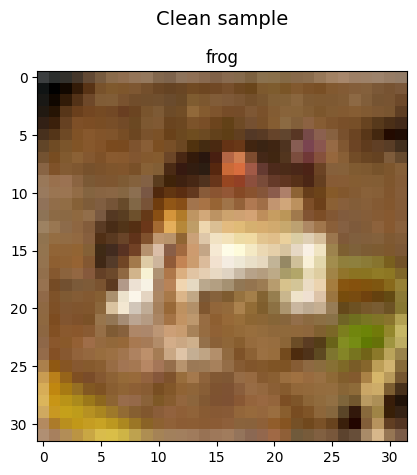

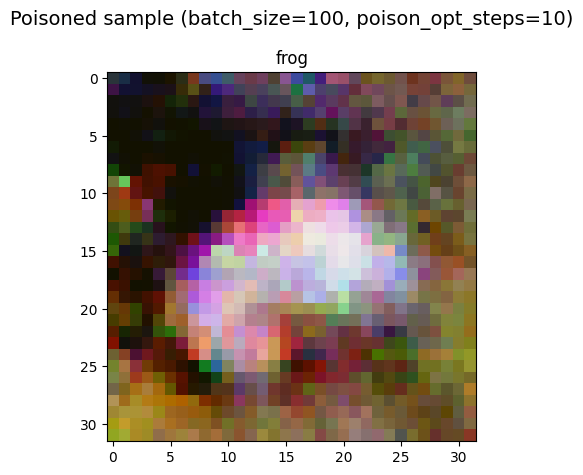

In [14]:
test_attack(net, criterion, train_loader, poison_opt_steps=10);

In [ ]:
# SGD is more vulnerable to gradient attacks
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
for epoch in trange(epochs, desc='Train epochs', unit='epoch', leave=True):
    train_epoch_with_poisons(
        net, train_loader,
        criterion, opt,
        poison_opt_steps=5, alpha_poison=0.2
    )
    test_epoch(net, val_loader, criterion, keep_pbars=True, metric=metric)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:13<00:00, 616.23it/s, MulticlassAccuracy=0.286, avg_loss=1.95]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:14<00:00, 603.86it/s, MulticlassAccuracy=0.365, avg_loss=1.62]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:15<00:00, 592.35it/s, MulticlassAccuracy=0.439, avg_loss=1.47]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:17<00:00, 578.06it/s, MulticlassAccuracy=0.456, avg_loss=1.35]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:19<00:00, 567.85it/s, MulticlassAccuracy=0.489, avg_loss=1.26]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:19<00:00, 565.03it/s, MulticlassAccuracy=0.512, avg_loss=1.17]


batch_size = 100, alpha = 0.2, poison_opt_steps = 2, ResNet18, SGD(weight_decay=0.0), epochs = 6:

accuracy : 58 -> 34

TODO: test with more poison steps or different lr for poison optimizer

#### Lower poisoning rate

In [18]:
net = ResNet18(num_classes=10).to(device)

In [19]:
opt = make_optimizer(net, opt_name='sgd', lr=lr, weight_decay=0.0)
for epoch in trange(epochs, desc='Train epochs', unit='epoch', leave=True):
    train_epoch_with_poisons(
        net, train_loader,
        criterion, opt,
        poison_opt_steps=5, alpha_poison=0.05
    )
    test_epoch(net, val_loader, criterion, keep_pbars=True, metric=metric)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:14<00:00, 607.32it/s, MulticlassAccuracy=0.298, avg_loss=1.97]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5118.23it/s, MulticlassAccuracy=0.248, avg_loss=1.98]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:15<00:00, 595.70it/s, MulticlassAccuracy=0.363, avg_loss=1.65]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5280.79it/s, MulticlassAccuracy=0.226, avg_loss=1.96]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:15<00:00, 597.12it/s, MulticlassAccuracy=0.422, avg_loss=1.49]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5118.73it/s, MulticlassAccuracy=0.256, avg_loss=2.12]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:17<00:00, 581.79it/s, MulticlassAccuracy=0.461, avg_loss=1.37]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5092.41it/s, MulticlassAccuracy=0.289, avg_loss=2.08]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:26<00:00, 521.86it/s, MulticlassAccuracy=0.525, avg_loss=1.27]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4510.24it/s, MulticlassAccuracy=0.291, avg_loss=1.96]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:19<00:00, 565.75it/s, MulticlassAccuracy=0.538, avg_loss=1.18]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4792.73it/s, MulticlassAccuracy=0.307, avg_loss=1.87]


Result : accuracy drops to 30 %

#### Using Adam optimizer for training

In [22]:
net = ResNet18(num_classes=10).to(device)

In [23]:
# Adam regularizes the parameters so it is more robust to gradient attacks
opt = make_optimizer(net, opt_name='adam', lr=lr)
for epoch in trange(epochs, desc='Train epochs', unit='epoch', leave=True):
    train_epoch_with_poisons(
        net, train_loader,
        criterion, opt,
        poison_opt_steps=5, alpha_poison=0.2
    )
    test_epoch(net, val_loader, criterion, keep_pbars=True, metric=metric)

Train epochs:   0%|          | 0/6 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `total_variation` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `total_variation` from `torchmetrics.image` instead.
  _future_warning(


Train loop: 100%|██████████| 45000/45000 [01:15<00:00, 595.14it/s, MulticlassAccuracy=0.585, avg_loss=1.38]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 5071.49it/s, MulticlassAccuracy=0.373, avg_loss=2]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:21<00:00, 551.54it/s, MulticlassAccuracy=0.638, avg_loss=0.977]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4953.01it/s, MulticlassAccuracy=0.45, avg_loss=1.77]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:22<00:00, 545.28it/s, MulticlassAccuracy=0.734, avg_loss=0.807]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4815.17it/s, MulticlassAccuracy=0.49, avg_loss=1.41]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:24<00:00, 529.75it/s, MulticlassAccuracy=0.774, avg_loss=0.683]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4728.32it/s, MulticlassAccuracy=0.587, avg_loss=1.23]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:24<00:00, 531.89it/s, MulticlassAccuracy=0.774, avg_loss=0.606]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4697.05it/s, MulticlassAccuracy=0.544, avg_loss=1.55]


Train loop:   0%|          | 0/45000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 45000/45000 [01:24<00:00, 535.00it/s, MulticlassAccuracy=0.809, avg_loss=0.534]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:01<00:00, 4882.84it/s, MulticlassAccuracy=0.611, avg_loss=1.45]


## Machine unlearning

In [ ]:
from .image_classification.unlearning import neg_grad_plus, unlearning_last_layers

TODO: test this against SGD first...

Refactor and create objects:
- GradientInverter
- PoisonedTrainer: store generated poisons

### Remaining tasks

- Refactoring
- Change reconstruction attack by starting from a random pattern
- _Little is Enough_ attack
- Mean gradient estimation with auxiliary dataset
- Testing against unlearning
- Testing with different configs (optimizer, number of epochs, batch size, models)